In [1]:
import os
import json

import numpy as np
from scipy.spatial.transform import Rotation as R
import pandas as pd
import matplotlib.pyplot as plt

import tools

# Pandas to display 3 decimal points
pd.options.display.float_format = '{:.3f}'.format
# Make matplotlib interractive in jupyter
%matplotlib widget

In [2]:
def plot_est(state_df, sample_rate, title):
    t = np.arange(len(state_df))/sample_rate
    # Plot the estimated locations, and angles over time, with time axis in seconds, in 2 subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 4))
    fig.suptitle(title)
    ax1.plot(t, state_df['x_w'], 'r', label='x')
    ax1.plot(t, state_df['y_w'], 'g', label='y')
    ax1.plot(t, state_df['z_w'], 'b', label='z')
    ax1.legend(loc='upper left')
    ax1.set_ylabel('Location (m)')
    ax2.plot(t, state_df['pi_w']/(2*np.pi)*360, 'r', label='pitch')
    ax2.plot(t, state_df['ro_w']/(2*np.pi)*360, 'g', label='roll')
    ax2.plot(t, state_df['ya_w']/(2*np.pi)*360, 'b', label='yaw')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Angle (deg)')
    plt.tight_layout()
    plt.show()


def run_location_tests(accelerometer, gyroscope, sample_rate, trackers: dict, plot_distance=True, plot_time=False):
    for i in range(len(accelerometer)):
        for tracker_name in trackers:
            trackers[tracker_name].add_measurement(accelerometer[i], gyroscope[i])

    df_list = [trackers[tracker_name].get_state_history_df() for tracker_name in trackers]
    # Print final locations
    # for tracker_name, df in zip(trackers, df_list):
    #     print(f'{tracker_name} Final Location: {df.iloc[-1]["x_w"]:0.3f}, {df.iloc[-1]["y_w"]:0.3f}, {df.iloc[-1]["z_w"]:0.3f}')

    if plot_distance:
        # Plot the estimated locations over time, with time axis in seconds
        plt.figure()
        for tracker_name, df in zip(trackers, df_list):
            plt.plot(df['x_w'].to_numpy(), df['y_w'].to_numpy(), label=tracker_name)
        plt.legend(loc='upper left')
        plt.xlabel('x position (m)')
        plt.ylabel('y position (m)')
        plt.tight_layout()
        plt.show()

    if plot_time:
        for tracker_name, df in zip(trackers, df_list):
            plot_est(df, sample_rate, tracker_name)

def test_file(file, calibration, plot_time=False, plot_distance=False, plot_data=False, settle_time=3):
    accelerometer, gyroscope, sample_rate, temperature, temperature_sample_rate = tools.read_data_file(
        os.path.join('..', 'tmp', file), lowpass=150, settle_time=settle_time
    )
    # Implement calibration
    accelerometer, gyroscope = tools.apply_calibration(accelerometer, gyroscope, temperature, calibration)

    # Get initial rotation
    init_r = tools.Location3d.initial_rotation_from_accelerometer(accelerometer, sample_rate, length=0.25)

    if plot_data:
        tools.plot_data(accelerometer, gyroscope, sample_rate, f'{os.path.basename(file)}', temperature, temperature_sample_rate)
        tools.plot_data(init_r.apply(accelerometer), gyroscope, sample_rate, f'Rotated: {os.path.basename(file)}', temperature, temperature_sample_rate)

    # Process noise covariance (Too slow to react? Increase Q; Too sensitive to noise? Decrease the Q)
    config = tools.UkfConfig(
        state_n=len(tools.Location3d.state_names), measurement_n=6,
        alpha=1e-3, beta=2, kappa=0,
        Q=1e-4, P=1e-6, R=np.array(calibration['R']),
        init_r=init_r
    )
    # ukf_obj = tools.Location3dUkf(sample_rate=sample_rate, config=config)
    dr_obj = tools.Location3d(sample_rate=sample_rate, init_r=init_r)
    # dr_obj = tools.Location3d(sample_rate=sample_rate, init_r=init_r.inv())

    run_location_tests(
        # accelerometer, gyroscope, sample_rate, {'ukf': ukf_obj, 'dr': dr_obj}, plot_time=True
        accelerometer, gyroscope, sample_rate, {'dr': dr_obj}, plot_time=plot_time, plot_distance=plot_distance,
    )
    dr_df = dr_obj.get_state_history_df()
    final_x = dr_df.iloc[-1]["x_w"]
    final_y = dr_df.iloc[-1]["y_w"]
    final_z = dr_df.iloc[-1]["z_w"]

    init_euler = init_r.as_euler('xyz', degrees=True)

    # Calculate the integral of the rotated accelerometer vector to get an ideal velocity and distance
    rotated_accelerometer = init_r.apply(accelerometer)
    velocity = np.cumsum(rotated_accelerometer - np.array([0, 0, tools.GRAVITY]), axis=0) / sample_rate
    distance = np.cumsum(velocity, axis=0) / sample_rate

    return {
        'file': os.path.basename(file),
        'temperature': np.mean(temperature),
        'init_pitch': init_euler[0],
        'init_roll': init_euler[1],
        'init_yaw': init_euler[2],
        'mag_a': np.mean(np.linalg.norm(accelerometer, axis=1)),
        'final_x': final_x,
        'final_y': final_y,
        'final_z': final_z,
        'distance': np.linalg.norm([final_x, final_y, final_z]),
        'distance_sum': np.linalg.norm(distance[-1]),
        'xy_distance': np.linalg.norm([final_x, final_y]),
        'xy_distance_sum': np.linalg.norm(distance[-1][0:2]),
    }

In [3]:
# Read calibration data
file = 'calibration.json'
with open(file) as f:
    calibration = json.load(f)

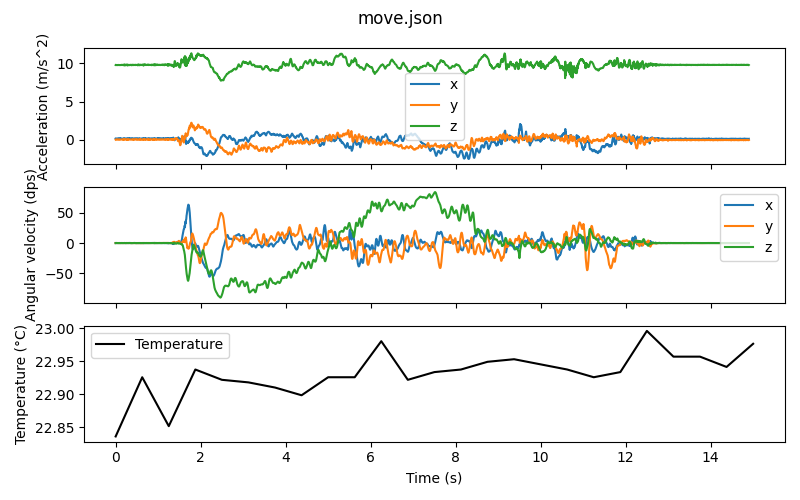

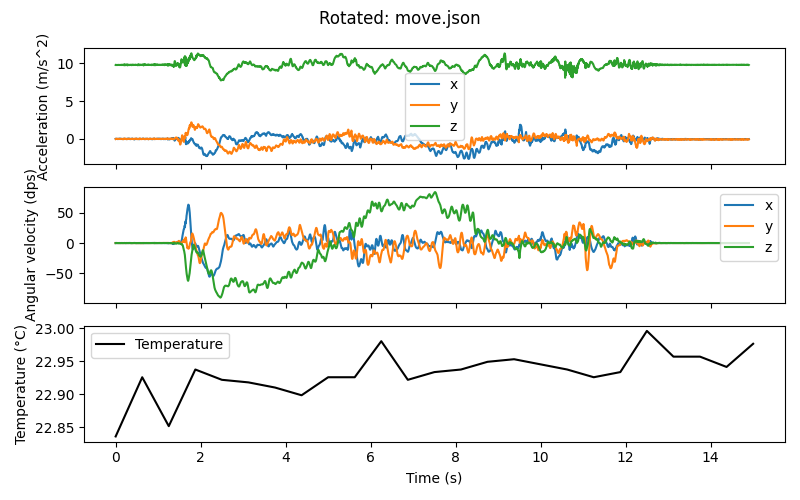

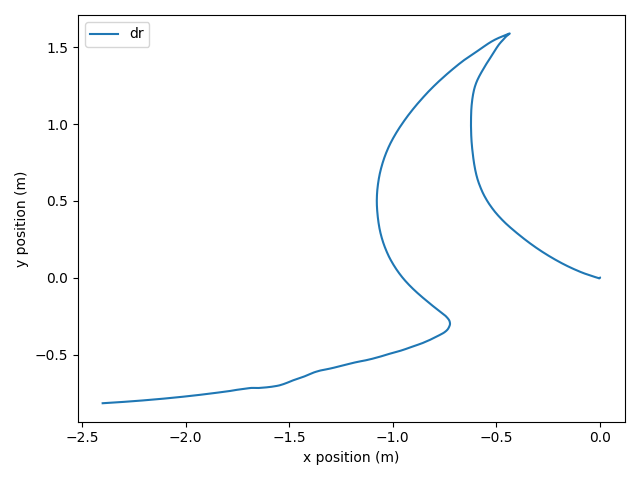

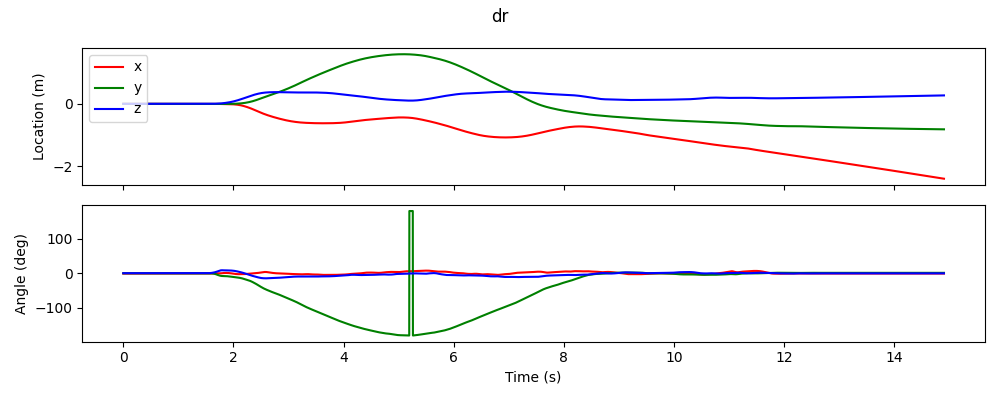

{'file': 'move.json',
 'temperature': 22.931875,
 'init_pitch': 0.229693605564325,
 'init_roll': -0.948669854822831,
 'init_yaw': 0.0,
 'mag_a': 9.833504580456195,
 'final_x': -2.3998187615730506,
 'final_y': -0.8171958911711202,
 'final_z': 0.26987822180664933,
 'distance': 2.5494653297408245,
 'distance_sum': 39.0120607112071,
 'xy_distance': 2.5351408664894683,
 'xy_distance_sum': 38.94250577304757}

In [4]:
test_file('test_5v/move.json', calibration, plot_time=True, plot_distance=True, plot_data=True, settle_time=0.1)
# test_file('cal_5v/cal_31.json', calibration, plot_time=True, plot_distance=True, plot_data=True)

In [5]:
cal_path = os.path.join('..', 'tmp', 'cal_5v')
# Get list of all JSON files in the path 
file_names = sorted([os.path.join(cal_path, f) for f in os.listdir(cal_path) if f.endswith('.json')])

df = []
for file in file_names:
    df.append(test_file(file, calibration))
df = pd.DataFrame(df)

temperature        1.000
init_pitch        -0.366
mag_a             -0.340
final_z           -0.327
init_roll         -0.194
xy_distance        0.165
distance           0.123
final_x            0.118
distance_sum       0.096
final_y            0.081
xy_distance_sum    0.077
init_yaw          -0.068
Name: temperature, dtype: float64

,file,temperature,init_pitch,init_roll,init_yaw,mag_a,final_x,final_y,final_z,distance,distance_sum,xy_distance,xy_distance_sum
0,cal_1.json,24.544,-179.708,-16.793,-0.000,9.797,-0.201,0.259,-0.453,0.559,0.482,0.328,0.164
1,cal_10.json,23.953,0.332,13.128,0.000,9.781,0.133,0.135,-1.529,1.541,1.530,0.190,0.060
2,cal_11.json,23.899,0.768,35.878,0.000,9.768,0.326,0.576,-2.594,2.677,2.598,0.662,0.154
3,cal_12.json,23.799,-0.511,-34.953,0.000,9.834,0.049,0.014,2.209,2.209,2.210,0.052,0.085
4,cal_13.json,23.805,-1.535,-59.080,-0.000,9.830,-0.002,0.182,1.901,1.910,1.903,0.182,0.071
5,cal_14.json,22.710,-5.807,0.074,0.000,9.810,0.139,0.098,0.469,0.499,0.478,0.170,0.092
6,cal_15.json,22.830,-17.276,0.122,0.000,9.817,-0.100,-0.108,0.968,0.980,0.979,0.147,0.144
7,cal_16.json,22.963,-29.141,0.072,0.000,9.826,0.086,-0.089,1.695,1.700,1.707,0.124,0.200
8,cal_17.json,23.114,-45.745,0.397,0.000,9.830,-0.181,0.122,1.945,1.957,1.947,0.218,0.102
9,cal_18.json,23.450,-65.824,0.655,0.000,9.827,0.011,-0.003,0.137,0.138,0.138,0.012,0.005


,temperature,init_pitch,init_roll,init_yaw,mag_a,final_x,final_y,final_z,distance,distance_sum,xy_distance,xy_distance_sum
count,55.000,55.000,55.000,55.000,55.000,55.000,55.000,55.000,55.000,55.000,55.000,55.000
mean,24.188,1.957,0.977,0.000,9.802,0.024,0.071,-0.136,1.172,1.107,0.377,0.201
std,0.869,106.930,35.636,0.000,0.018,0.221,0.625,1.241,0.778,0.764,0.548,0.483
min,22.710,-179.708,-72.375,-0.000,9.768,-0.684,-0.832,-2.594,0.138,0.085,0.010,0.005
25%,23.483,-55.785,-22.091,0.000,9.789,-0.087,-0.189,-1.044,0.577,0.483,0.164,0.061
50%,24.095,-1.535,0.074,0.000,9.803,-0.002,0.036,0.018,1.061,0.987,0.287,0.102
75%,24.528,58.218,24.345,0.000,9.816,0.160,0.185,0.847,1.657,1.651,0.433,0.191
max,27.140,180.000,67.504,0.000,9.834,0.523,4.109,2.209,4.219,3.745,4.111,3.623


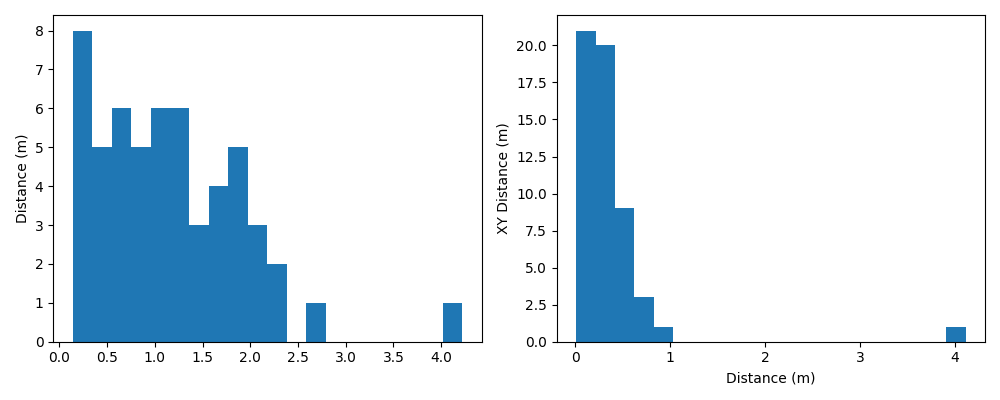

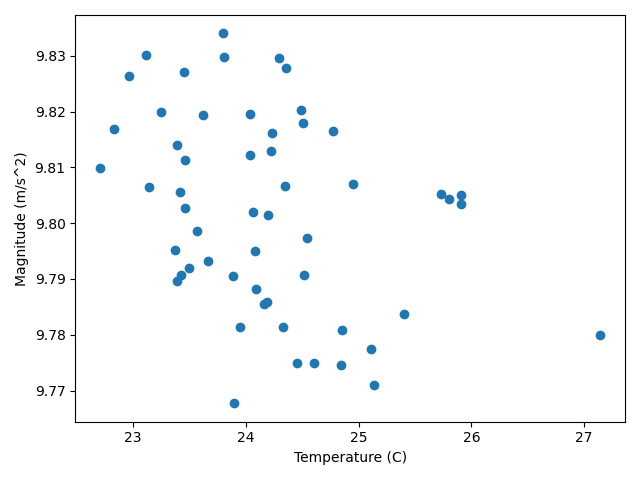

Pearson correlation between temperature and magnitude: -0.3397416225950746


In [8]:
# Get the cross correlation for temperature in the dataframe
corr = df.drop(columns=['file']).corr()
# Display sorted by absolute value
display(corr['temperature'].sort_values(key=lambda x: np.abs(x), ascending=False))

display(df)
display(df.describe())

# Display a historgram of the distance and the xy_distance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.hist(df['distance'], bins=20)
ax1.set_ylabel('Distance (m)')
ax2.hist(df['xy_distance'], bins=20)
ax2.set_xlabel('Distance (m)')
ax2.set_ylabel('XY Distance (m)')
plt.tight_layout()
plt.show()

# Display distance vs temperature
plt.figure()
plt.plot(df['temperature'], df['mag_a'], 'o')
plt.xlabel('Temperature (C)')
plt.ylabel('Magnitude (m/s^2)')
plt.tight_layout()
plt.show()

In [7]:
cal_path = os.path.join('..', 'tmp', 'test_5v')
# Get list of all JSON files in the path 
file_names = sorted([os.path.join(cal_path, f) for f in os.listdir(cal_path) if f.endswith('.json')])

test_df = []
for file in file_names:
    test_df.append(test_file(file, calibration))
test_df = pd.DataFrame(test_df)
display(test_df)

,file,temperature,init_pitch,init_roll,init_yaw,mag_a,final_x,final_y,final_z,distance,distance_sum,xy_distance,xy_distance_sum
0,move.json,22.940,-5.244,0.064,0.000,9.834,20.954,-83.320,-4.773,86.047,43.528,85.914,43.483
1,static_table.json,23.718,-0.048,1.428,-0.000,9.795,-0.157,1.944,-3.174,3.725,3.185,1.950,0.269
2,table_test.json,21.261,0.201,-0.001,0.000,9.801,3.164,0.864,-0.844,3.387,0.951,3.280,0.442
